# Region Segmentation Using Traditional Techniques

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def segment_mask(face_img):
    gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)
    threshold_type = cv2.THRESH_BINARY if mean_intensity > 127 else cv2.THRESH_BINARY_INV
    
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    _, binary_mask = cv2.threshold(blurred, 0, 255, threshold_type + cv2.THRESH_OTSU)
    edges = cv2.Canny(blurred, 225, 250)
    combined = cv2.bitwise_or(binary_mask, edges)
    
    kernel = np.ones((3, 3), np.uint8)
    refined_mask = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    return refined_mask

In [3]:
input_dir = "MSFD/1/face_crop"
output_dir = "MSFD/1/Segemented"
predicted_dir = "MSFD/1/Segemented"
ground_truth_dir = "MSFD/1/face_crop_segmentation"

os.makedirs(output_dir, exist_ok=True)

In [4]:
for filename in os.listdir(input_dir):
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, f"segmented_{filename}")
    
    face_img = cv2.imread(input_path)
    if face_img is None:
        print(f"Skipping unreadable file: {filename}")
        continue
    
    segmented_mask = segment_mask(face_img)
    cv2.imwrite(output_path, segmented_mask)

print("Segmentation complete for all images.")

Segmentation complete for all images.


In [5]:
def dice_coefficient(mask1, mask2):
    mask2 = cv2.resize(mask2, (mask1.shape[1], mask1.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask1, mask2 = mask1.astype(np.bool_), mask2.astype(np.bool_)
    intersection = np.logical_and(mask1, mask2).sum()
    return (2. * intersection) / (mask1.sum() + mask2.sum() + 1e-6)

In [6]:
predicted_files = sorted(os.listdir(predicted_dir))
ground_truth_files = sorted(os.listdir(ground_truth_dir))

assert len(predicted_files) == len(ground_truth_files), "Mismatch in file counts!"

dice_scores = []
for pred_file, gt_file in zip(predicted_files, ground_truth_files):
    pred_path = os.path.join(predicted_dir, pred_file)
    gt_path = os.path.join(ground_truth_dir, gt_file)
    
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    
    if pred_mask is None or gt_mask is None:
        print(f"Skipping: {pred_file} or {gt_file} could not be loaded.")
        continue
    
    pred_mask, gt_mask = (pred_mask > 127).astype(np.uint8), (gt_mask > 127).astype(np.uint8)
    dice = dice_coefficient(pred_mask, gt_mask)
    dice_scores.append(dice)

average_dice = np.mean(dice_scores) if dice_scores else 0
print(f"\nAverage Dice Coefficient: {average_dice:.4f}")


Average Dice Coefficient: 0.4608


# Mask Segmentation Using U-Net

In [ ]:
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Paths to images and masks
IMAGE_PATH = "./face_crop"
MASK_PATH = "./face_crop_segmentation"

In [5]:
# Load dataset
def load_dataset(image_path, mask_path):
    images = []
    masks = []
    for file in os.listdir(image_path):
        if file.endswith(('jpg', 'png', 'jpeg')):
            # Read and convert to RGB
            img = cv2.imread(os.path.join(image_path, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (128, 128))
            img = img / 255.0  # Normalize to [0, 1]

            # Read mask (grayscale)
            mask = cv2.imread(os.path.join(mask_path, file), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (128, 128))
            mask = mask / 255.0  # Normalize to [0, 1]
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    
            images.append(img)
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    return images, masks

In [ ]:
def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(64, (3, 3), padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(128, (3, 3), padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(256, (3, 3), padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv2D(256, (3, 3), padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    u6 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(128, (3, 3), padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    u7 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Conv2D(64, (3, 3), padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    return model

In [7]:
# Load the data
X, y = load_dataset(IMAGE_PATH, MASK_PATH)

# # Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [9]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Build and compile U-Net model
unet = build_unet()
unet.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coefficient])

# Train model
history = unet.fit(X_train, y_train, validation_split=0.1, batch_size=16, 
                   epochs=20, callbacks=[early_stopping])

2025-03-24 03:32:12.087465: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-24 03:32:12.087692: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-24 03:32:12.087700: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1742767332.088153 5638208 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742767332.091298 5638208 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/25


2025-03-24 03:32:19.286341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


423/423 ━━━━━━━━━━━━━━━━━━━━ 184s 414ms/step - accuracy: 0.5397 - dice_coefficient: 0.7847 - loss: 0.2153 - val_accuracy: 0.6122 - val_dice_coefficient: 0.8052 - val_loss: 0.1948
Epoch 2/25
423/423 ━━━━━━━━━━━━━━━━━━━━ 172s 406ms/step - accuracy: 0.6028 - dice_coefficient: 0.9124 - loss: 0.0876 - val_accuracy: 0.6012 - val_dice_coefficient: 0.9149 - val_loss: 0.0851
Epoch 3/25
423/423 ━━━━━━━━━━━━━━━━━━━━ 170s 403ms/step - accuracy: 0.6081 - dice_coefficient: 0.9336 - loss: 0.0664 - val_accuracy: 0.5830 - val_dice_coefficient: 0.8976 - val_loss: 0.1025
Epoch 4/25
423/423 ━━━━━━━━━━━━━━━━━━━━ 171s 403ms/step - accuracy: 0.6117 - dice_coefficient: 0.9377 - loss: 0.0623 - val_accuracy: 0.5890 - val_dice_coefficient: 0.9094 - val_loss: 0.0906
Epoch 5/25
423/423 ━━━━━━━━━━━━━━━━━━━━ 170s 403ms/step - accuracy: 0.6111 - dice_coefficient: 0.9426 - loss: 0.0574 - val_accuracy: 0.6078 - val_dice_coefficient: 0.9309 - val_loss: 0.0691
Epoch 6/25
423/423 ━━━━━━━━━━━━━━━━━━━━ 171s 403ms/step - acc

59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step


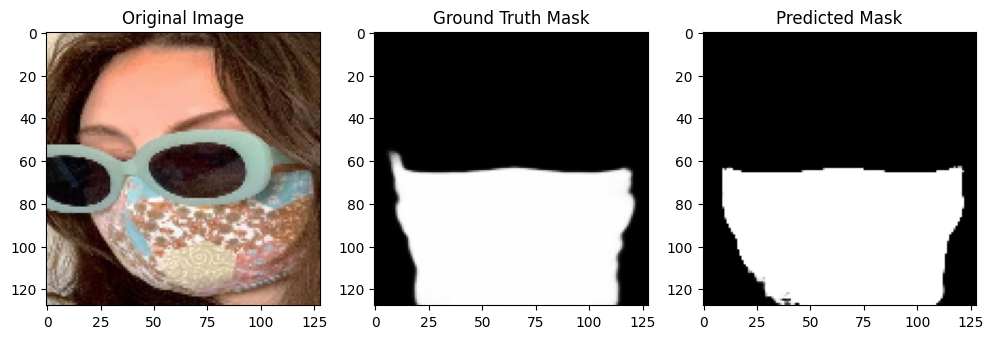

In [11]:
# Predict masks
predicted_masks = unet.predict(X_test)

# Show example prediction
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_test[1])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[0].squeeze(), cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_masks[0].squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.show()